# TITLE

## Introduction

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* Clearly state the question you will try to answer with your project
* Identify and describe the dataset that will be used to answer the question

## Preliminary exploratory data analysis

* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only **training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only **training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

## Methods

* Explain how you will conduct either your data analysis and which variables/columns you will use. *Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?*
* Describe at least one way that you will visualize the results

## Expected outcomes and significance

* What do you expect to find?
* What impact could such findings have?
* What future questions could this lead to?

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(stringi)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Step 1: reading and tidying the data**

In [4]:
#loading dataset
players_url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_stats <- read_csv(players_url)

#tidying column names
names(player_stats) <- gsub(" ", "_", names(player_stats)) %>%
                        tolower()

#tidying "active" column
player_stats$active[is.na(player_stats$active)] <- "No"

tidy_player_stats <- player_stats %>%
        
    #separating columns with multiple variables
        separate(age, sep = " ", into = c("age", "birthdate"), convert = TRUE) %>%
                        
        separate(current_rank, sep = " ", into = c("current_rank", "current_rating"), convert = TRUE) %>%
        separate(best_rank, sep = " ", into = c("best_rank", "best_rank_date"), convert = TRUE) %>%
                        
        separate(favorite_surface, sep = " ", into = c("favorite_surface", "favorite_surface_percent")) %>%
        
        separate(current_elo_rank, sep = " ", into = c("current_elo_rank", "current_elo_rating"), convert = TRUE) %>% 
        separate(best_elo_rank, sep = " ", into = c("best_elo_rank", "best_elo_rank_date"), convert = TRUE) %>%

        separate(peak_elo_rating, sep = " ", into = c("peak_elo_rating", "peak_elo_rating_date"), convert = TRUE) %>%

        separate(goat_rank, sep = " ", into = c("goat_rank", "goat_rating"), convert = TRUE) %>%

    #further tidying (e.g. removing brackets, changing data type)
        mutate(current_rating = parse_number(current_rating), 
                best_rank_date = str_replace(best_rank_date, "[(]", ""), best_rank_date = str_replace(best_rank_date, "[)]", ""), best_rank_date = as.Date(best_rank_date, format = '%d-%m-%Y'),
                height_cm = parse_number(height), weight_kg = parse_number(weight), prize_money = parse_number(prize_money), 
                current_elo_rating = parse_number(current_elo_rating),
                best_elo_rank_date = str_replace(best_elo_rank_date, "[(]", ""), best_elo_rank_date = str_replace(best_elo_rank_date, "[)]", ""), best_elo_rank_date = as.Date(best_elo_rank_date, format = '%d-%m-%Y'),
                peak_elo_rating_date = str_replace(peak_elo_rating_date, "[(]", ""), peak_elo_rating_date = str_replace(peak_elo_rating_date, "[)]", ""), peak_elo_rating_date = as.Date(peak_elo_rating_date, format = '%d-%m-%Y'),
                last_appearance = as.Date(last_appearance, format = '%d-%m-%Y'),
                goat_rating = parse_number(goat_rating),
                active = as.factor(active)) %>%
     
    #selecting columns to plot
        select(current_rank, seasons) %>%
                        
        arrange(current_rank) %>%
        filter(!is.na(current_rank) & !is.na(seasons))

head(tidy_player_stats)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 41 rows [3, 5, 6, 20, 21, 53, 58, 66, 89, 119, 129, 141, 142, 152, 155, 165, 188, 193, 205, 212, ...].”


current_rank,seasons
<int>,<dbl>
1,19
2,17
3,22
4,5
5,10
6,4


**Step 2: Splitting into training and test data**

In [6]:
#setting the seed to ensure split is reproducible
set.seed(1)

stats_split <- initial_split(tidy_player_stats, prop = 0.75, strata = current_rank)
stats_training <- training(stats_split)
stats_testing <- testing(stats_split)

**Step 3: visualize training data by plotting current player rank vs. number of seasons played**

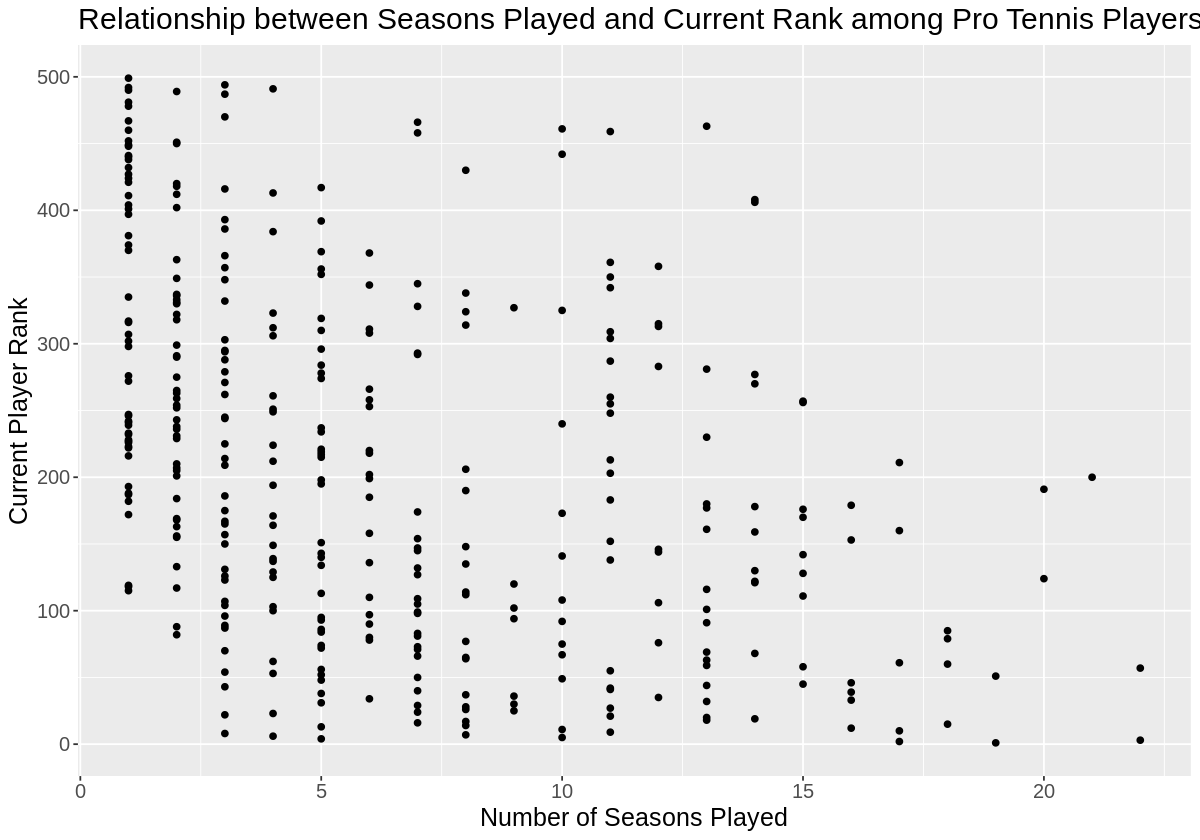

In [7]:
options(repr.plot.height = 7, repr.plot.width = 10)

rank_vs_seasons <- ggplot(tidy_player_stats, aes(x = seasons, y = current_rank)) +
        geom_point() +
        labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Relationship between Seasons Played and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_seasons

**Step 4: KNN regression**

In [8]:
#create the recipe to standardize the data
stats_recipe <- recipe(current_rank ~ seasons, data = stats_training) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

#split the training data into training and validation for a 5-fold cross-validation
stats_vfold <- vfold_cv(stats_training, v = 5, strata = current_rank)

#create the model specification to tune the number of nearest neighbors ("K")
stats_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("regression")

#identify which K values to test
gridvals <- tibble(neighbors = seq(1:50))

#put together in a workflow
stats_workflow <- workflow() %>%
        add_recipe(stats_recipe) %>%
        add_model(stats_tune)

#perform the cross-validation to choose the best K value
stats_tune_results <- stats_workflow %>%
        tune_grid(resamples = stats_vfold, grid = gridvals) %>%
        collect_metrics() %>%
        filter(.metric == "rmse") %>%
        arrange(mean) %>%
        slice(1)
stats_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
34,rmse,standard,119.3712,5,1.603112,Model34


.pred,current_rank,seasons
<dbl>,<int>,<dbl>
119.2941,1,19
122.6765,7,8
122.6765,14,8
221.9412,21,11
139.8235,33,16
168.7059,34,6


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,123.5772536
rsq,standard,0.1416793
mae,standard,100.2749361


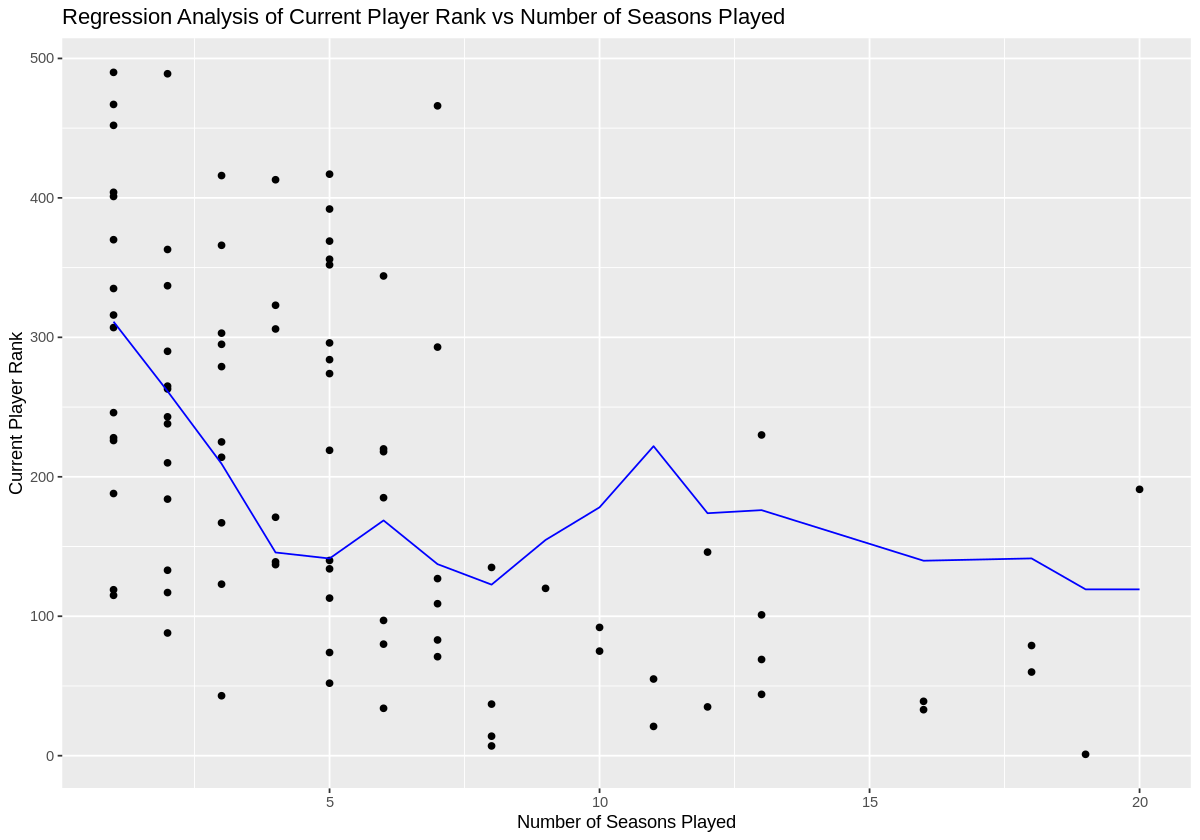

In [9]:
#pull the best K value
neighbor_tune <- stats_tune_results %>%
        pull(neighbors) 

#respecify the model specification with this K value
stats_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbor_tune) %>%
        set_engine("kknn") %>%
        set_mode("regression")

#retrain the model
stats_fit <- workflow() %>%
        add_recipe(stats_recipe) %>%
        add_model(stats_spec) %>%
        fit(data = stats_training)

#predict using the testing data
stats_predictions <- stats_fit %>%
        predict(stats_testing) %>%
        bind_cols(stats_testing)
head(stats_predictions)

#get RMSPE 
stats_summary <- stats_predictions %>%
        metrics(truth = current_rank, estimate = .pred)
stats_summary

#plot model over testing data
stats_plot <- ggplot(stats_predictions, aes(x = seasons, y = current_rank)) +
            geom_point() +
            geom_line(stats_predictions, mapping = aes(x = seasons, y = .pred), color = "blue") +
            labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Regression Analysis of Current Player Rank vs Number of Seasons Played")
stats_plot

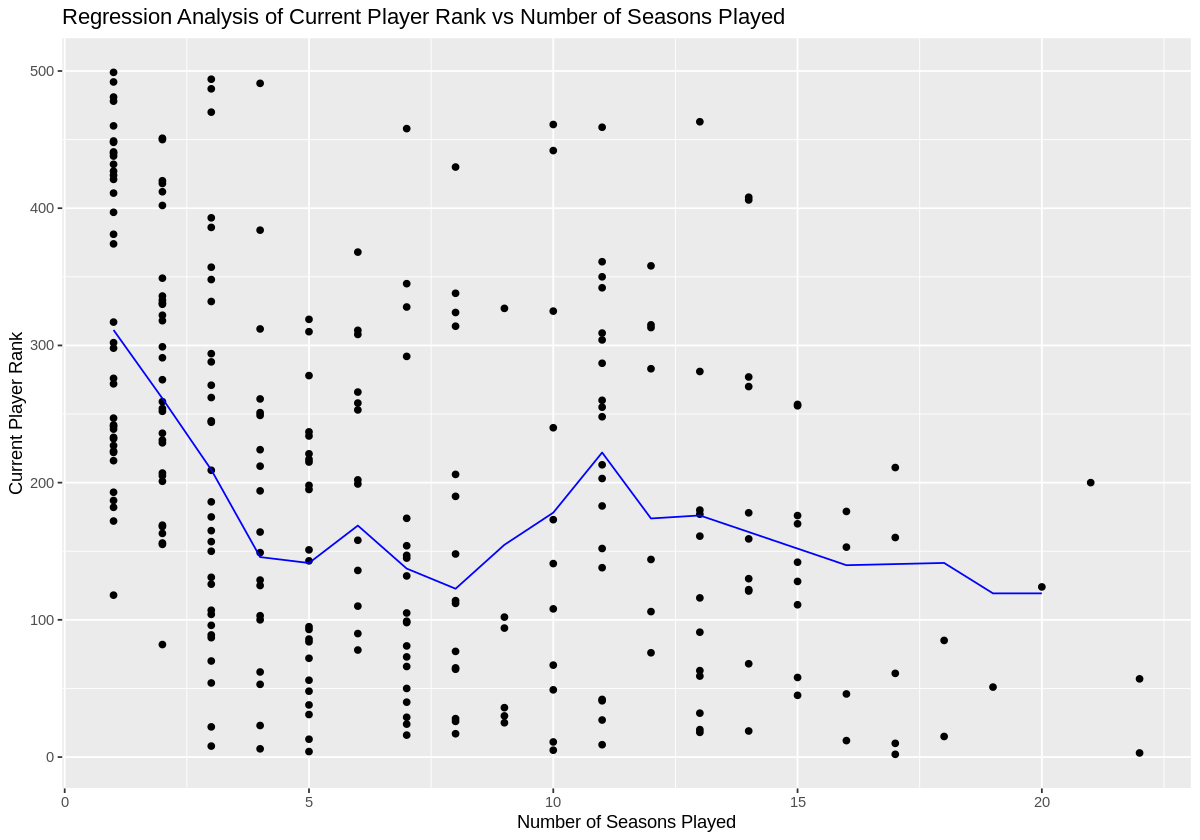

In [10]:
stats_plot <- ggplot(stats_training, aes(x = seasons, y = current_rank)) +
            geom_point() +
            geom_line(stats_predictions, mapping = aes(x = seasons, y = .pred), color = "blue") +
            labs(x = "Number of Seasons Played", y = "Current Player Rank", title = "Regression Analysis of Current Player Rank vs Number of Seasons Played")
stats_plot